In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from gaussian_process import Gaussian_Process, Path_Tracker
from optimizers import *

## Simple linesearch

In [2]:
#Newton Raphson (wtf, y?)
def energy(x, x1, x2):
    return (x - x1)*(x - x2)

def force(x, x1, x2):
    return 2*x - (x1 + x2)

def func2D(coord):
    x, y = coord
    return np.log(2*(y-x**2)**2 + (1-x)**2 + 1)

def force_func2D(coord):
    x, y = coord
    val = 2*(y-x**2)**2 + (1-x)**2 + 1
    return -np.array([-8*(y-x)*x - 2*(1 - x), 4*(y-x)])/val

def optimize(x_guess, energy, force, *par):
    x0 = x_guess
    f0 = force(x0, *par)
    if np.linalg.norm(f0) < 1e-4:
        print("Good guess!")
        return x0, 1
    x1 = x0 - energy(x0, *par) * (f0**(-1))
    f1 = force(x1, *par)
    n_eval = 2
    while np.linalg.norm(f1 - f0) > 1e-4:
        x0 = x1
        f0 = f1
        
        x1 = x0 - energy(x0, *par) * (f0**(-1))
        f1 = force(x1, *par)
        n_eval += 1
    
    return x1, n_eval

def grad_desc(x_guess, energy, force, step, prec, *par):
    x0 = x_guess
    f0 = force(x0, *par)
    if np.linalg.norm(f0) < prec:
        print("Good guess!")
        return x0, 1
    
    x1 = x0 + step * f0
    f1 = force(x1)
    
    for i in range(1998):
        x0 = x1.copy()
        f0 = f1.copy()
        
        x1 =x0 + f0 * step
        f1 = force(x1)
        if np.linalg.norm(f1 - f0) < prec:
            return x1, f1, i + 2
        
    return x1, f1, -1

In [3]:
N = []
for i in range(10000):
    x1 = np.random.random() * 4
    x2 = np.random.random() * 5 + 5
    guess = np.random.random() * 10
    x1, n_eval = optimize(guess, energy, force, x1, x2)
    
    N.append(n_eval)

np.mean(N)

5.8682

## Analytical 2D function

In [4]:
answer = np.array([1.0, 1.0])
n_correct = 0
n_iter = 0
for i in range(1000):
    guess = np.random.random(2)*4 - 2
    coords, _, evals = grad_desc(guess, func2D, force_func2D, 1e-2, 1e-4)
    if evals != -1:
        n_correct += 1
        n_iter += evals

print(n_correct, n_iter/n_correct)

1000 714.127


## Steepest descend

In [5]:
def search_old(x_init, f_init, e_init, step, f_func, e_func, nsteps = 100, prec = 1e-4):
    shift = (-1, -1, -1)
    f_roll = np.zeros((3, len(x_init)))
    e_roll = np.zeros(3)
    x_roll = np.zeros((3,len(x_init)))
    
    f_norm = np.linalg.norm(f_init)
    f_dir = f_init.copy()/f_norm
    x_roll[0] = x_init
    f_roll[0] = f_init
    e_roll[0] = e_init
    
    x_roll[1] = x_roll[0] + step*(f_roll[0]@f_dir)*f_dir
    e_roll[1] = e_func(x_roll[1])
    f_new = f_func(x_roll[1])
    f_roll[1] = f_new
    
    if abs(f_new@f_dir) < prec:
        return x_roll[1], f_roll[1], e_roll[1], 1
    
    dx = (x_roll[1] - x_roll[0])@f_dir
    a2 = -(f_roll[1] - f_roll[0])@f_dir/dx #Could use many other expressions for a/b as we also have E
    b = sum((-f_roll[i] - a2*x_roll[i])@f_dir for i in range(2))/2
    x_roll[2] = -f_dir * b/a2
    e_roll[2] = e_func(x_roll[2])
    f_new = f_func(x_roll[2])
    f_roll[2] = f_new
    
    if abs(f_new@f_dir) < prec:
        return x_roll[2], f_roll[2], e_roll[2], 2
    
    for i in range(2, nsteps):
        f_old = f_new.copy()
        pf_vals = [abs(f_roll[j]@f_dir) for j in range(3)]
        i_max = np.argmax(pf_vals)
        i_min = np.argmin(pf_vals)
        i_mid = (set((0, 1, 2)) - set((i_max, i_min))).pop()
                
        dx = (x_roll[i_min]-x_roll[i_mid])@f_dir
        a2 = -(f_roll[i_min] - f_roll[i_mid])@f_dir/dx #Could use many other expressions as we also have E
        b = sum((-f_roll[i] - a2*x_roll[i])@f_dir for i in [i_mid, i_min])/2 #average b
        if np.linalg.norm(x_roll[i_min]@f_dir + b/a2*f_dir) < dx*5:
            x_roll[i_max] = -f_dir * b/a2
        else:
            x_roll[i_max] = x_roll[i_min] + f_roll[i_min]@f_dir
        # e_roll[i_max] = e_func(x_roll[i_max])
        f_new = f_func(x_roll[i_max])
        f_roll[i_max] = f_new
        
        if abs((f_new-f_old)@f_dir) < prec:
            return x_roll[i_max], f_roll[i_max], e_func(x_roll[i_max]), i #Doesnt use e_roll
            # return x_roll[i_max], f_roll[i_max], e_roll[i_max], i
            
    print("Not orthogonal")
    return x_roll[i_max], f_roll[i_max], i

In [6]:
def search_alt(x_init, f_init, e_init, step, f_func, e_func, nsteps = 100, prec = 1e-4):
    x0 = x_init.copy()
    f0 = f_init.copy()
    f_norm = np.linalg.norm(f_init)
    f_dir = f_init.copy()/f_norm
    
    
    x1 = x0 + step * f0
    f1 = f_func(x1)
    for i in range(nsteps):
        dx = (x1 - x0)@f_dir
        a2 = -(f1 - f0)@f_dir/dx # F_projected = -dE --> -(F2_projected - F1_projected)/(x2 - x1) = 2a
        if a2 > 0: #Checks if minimum or maximum
            b = -(f0 + f1 + a2*(x0 + x1))@f_dir/2 #Average of two b-values
            x0 = x1.copy()
            f0 = f1.copy()
            x1 = -f_dir * b/a2
        else:
            x0 = x1.copy()
            f0 = f1.copy()
            x1 = x0 + 0.1*step * f0@f_dir
        f1 = f_func(x1)
        if abs((f1 - f0)@f_dir) < prec:
            return x1, f1, i + 1
            
    return x1, f1, i + 1

In [7]:
def search_basic(x_init, f_init, e_init, step, f_func, e_func, nsteps = 100):
    init_eval = 0
    x0 = x_init.copy()
    f0 = f_init.copy()
    fnorm = np.linalg.norm(f0)
    f_dir = f_init.copy()/fnorm
    if fnorm < 1e-4:
        return x0, f0, 0
    
    x1 = x0 + step * f0
    f1 = f_func(x1)
    init_eval += 1
    
    # if f1@f_dir < 0:
    #     dx = (x1 - x0)@f_dir
    #     a2 = -(f1 - f0)@f_dir/dx # F_projected = -dE --> -(F2_projected - F1_projected)/(x2 - x1) = 2a
    #     if a2 > 0: #Checks if minimum or maximum
    #         b = -(f0 + f1 + a2*(x0 + x1))@f_dir/2 #Average of two b-values
    #         x0 = x1.copy()
    #         f0 = f1.copy()
    #         x1 = -f_dir * b/a2
    #         f1 = f_func(x1)
    #         init_eval += 1
            
    
    for i in range(nsteps):
        x0 = x1.copy()
        f0 = f1.copy()
        
        x1 =x0 + f0 @ f_dir * f_dir * step
        f1 = f_func(x1)
        if abs(f1@f_dir)<0.1*fnorm:
            return x1, f1, i + init_eval
        
    print("Not orthogonal")
    return x1, f1, -1

In [8]:
# def search(x_init, f_init, e_init, e_func, learning_rate, beta=0.5, gamma=0.1):
#     grad_dot = f_init@f_init  # Gradient squared
#     t = learning_rate
#     n_s = 0
#     # Backtracking step size adjustment
#     while e_func(x_init + t * f_init) > e_init - gamma * t * grad_dot:
#         t *= beta  # Reduce step size
#         n_s += 1
#     return t, n_s

In [9]:
# def linesearch_simple(guess, force, energy, prec, nsteps = 2000):
#     x0 = guess.copy()
#     f0 = force(x0)
#     e0 = energy(x0)
#     n_search = 0
#     # x1, f1, n_line = search(x0, f0, e0, step, force, energy)
#     for i in range(nsteps):
#         step, n_add = search(x0, f0, e0, energy, learning_rate = 0.1)
#         n_search += n_add
#         x1 = x0 + step * f0
#         f1 = force(x1)
#         e1 = energy(x1)
#         x0 = x1.copy()
#         f0 = f1.copy()
#         e0 = e1
    
#     if np.linalg.norm(f1 - f0) < prec:
#             return x1, i + n_search
    
#     return x1, -1, i

# def conj_gradient(guess, force, energy, prec, nsteps = 2000):
#     x1 = guess.copy()
#     f1 = force(x1)
#     h1 = f1.copy()
#     e1 = energy(x1)
#     n_eval = 1
#     for conj_i in range(nsteps):
#         for conjugation in range(len(guess)): #dimensionality
#             x0 = x1.copy()
#             f0 = f1.copy()
#             h0 = h1.copy()
#             e0 = e1
#             step, n_add = search(x0, f0, e0, energy, learning_rate = 0.1)
#             n_eval += n_add
            
#             x1 = x0 + step * f0
#             f1 = force(x1)
#             e1 = energy(x1)
            
#             if np.linalg.norm(f1 - f0) < 1e-4:
#                 return x1, n_eval + conj_i
#             gamma = (f1 - f0)@f1/(f0@f0)
#             h1 = f1 + gamma*h0
#         h1 = f1.copy() #restarts conjugation
        
#     #Didnt converge
#     return x1, -1

# def kinetic(p, mass):
#         if hasattr(p, '__len__'):
#             return p@p/(2*mass)
#         else:
#             return p**2/(2*mass)

# def velo_step(x, p, f, force, mass, dt):
#     p_half = p + dt/2 * f
#     x_new = x + dt/mass * p_half
#     f_new = force(x_new)
#     p_new = p_half + dt/2 * f_new
    
#     return x_new, p_new, f_new

# def velo_integrate(x0, p0, f0, force, mass, dt, steps = 20):
#     for velo in range(steps):
#         x0, p0, f0 = velo_step(x0, p0, f0, force, mass, dt)
#     return x0, p0, f0

# def HMC(guess, force, energy, prec, nsteps = 100, mass = 1, sigma = 1, dt = 1e-2, path = None):
#     dim = len(guess)
#     x0 = np.array(guess).copy()
#     p0 = np.random.normal(0.0, sigma, size = dim)
#     f0 = force(x0)
#     for momentum_step in range(nsteps):
#         x1, p1, f1 = velo_step(x0, p0, f0, force, mass, dt)
#         pot0 = energy(x0)
#         pot1 = energy(x1)
#         prob = np.exp(kinetic(p0, mass) + pot0 - (kinetic(p1, mass) + pot1))
        
#         p0 = np.random.normal(0.0, sigma, size = dim)
#         if np.random.random() < prob:
#             if path is not None:
#                 path.x_steps.append(x0)
#                 path.nloglike.append(pot0)
#             x0 = x1.copy()
#             f0 = f1.copy()
#             pot1 = pot0
        
#     return x0, pot0, -1

In [10]:
x0 = np.array([1, 1])
sigma = 1
np.random.normal(0, sigma, size = 2)

array([ 1.99024662, -0.74022944])

In [11]:
testM = np.array([[1,2,3],[4,5,6],[7,8,9]])
np.where(testM == np.max(testM))

(array([2]), array([2]))

In [12]:
answer = np.array([1.0, 1.0])
n_correct = 0
n_iter = 0
n_search = 0
x_avg = np.zeros(2)
def energy_force(par):
    return func2D(par), force_func2D(par)

for i in range(100):
    guess = np.random.random(2)*4 - 2
    coords, nlog, evals = conj_gradient(guess, energy_force, prec = 1e-4, nsteps = 200, path = None)
    if evals != -1:
        n_correct += 1
        n_iter += evals
        x_avg += coords

print(n_correct, n_iter/n_correct, x_avg/n_correct)

100 90.73 [0.48168283 0.93553008]


## Gaussian process

In [13]:
n_points = 15
rand_coords = np.random.random((n_points,2))*4 - np.array([2,1])
rand_vals = func2D(rand_coords.T)
plot_coords = np.random.random((1000, 2))*4 - np.array([2,1])

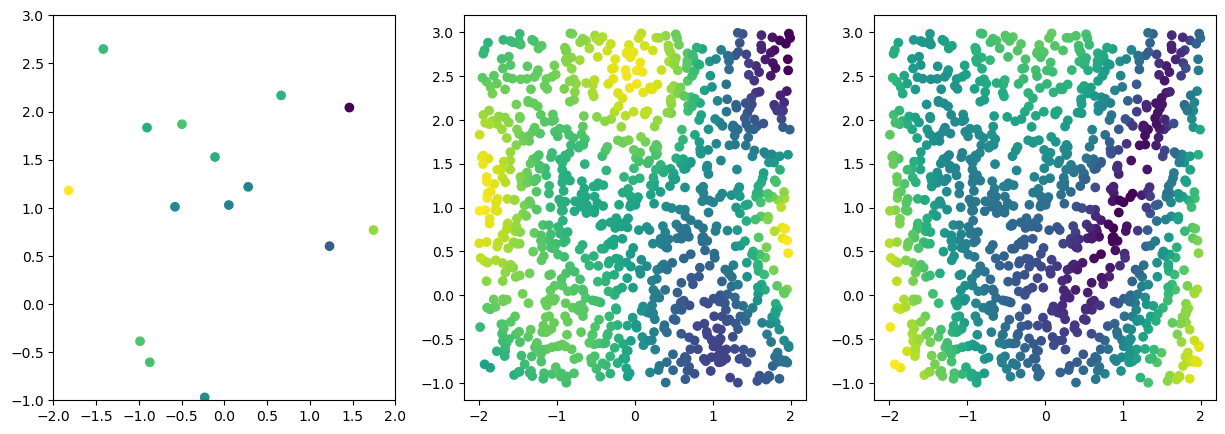

In [14]:
GP = Gaussian_Process(x_dat = rand_coords, t_dat = rand_vals, hyper_par = [1, 1], noise = 1e-2)
plot_vals = GP.predict(plot_coords)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 5))

ax1.scatter(rand_coords[:,0], rand_coords[:,1], c = rand_vals)
ax1.set_xlim(-2,2)
ax1.set_ylim(-1,3)
ax2.scatter(plot_coords[:,0], plot_coords[:,1], c = plot_vals)
ax3.scatter(plot_coords[:,0], plot_coords[:,1], c = func2D(plot_coords.T))

[0.99694948 2.33023571]
[1.10370703 4.05488202]
[1.12427624 4.38830221]
[1.10275678 3.99119059]
[1.10822384 3.88159355]
[1.09386567 3.72796042]
[1.11433821 3.98074284]
[1.10001648 3.83930074]
[1.10817998 3.85110648]
[1.11445108 3.90385041]


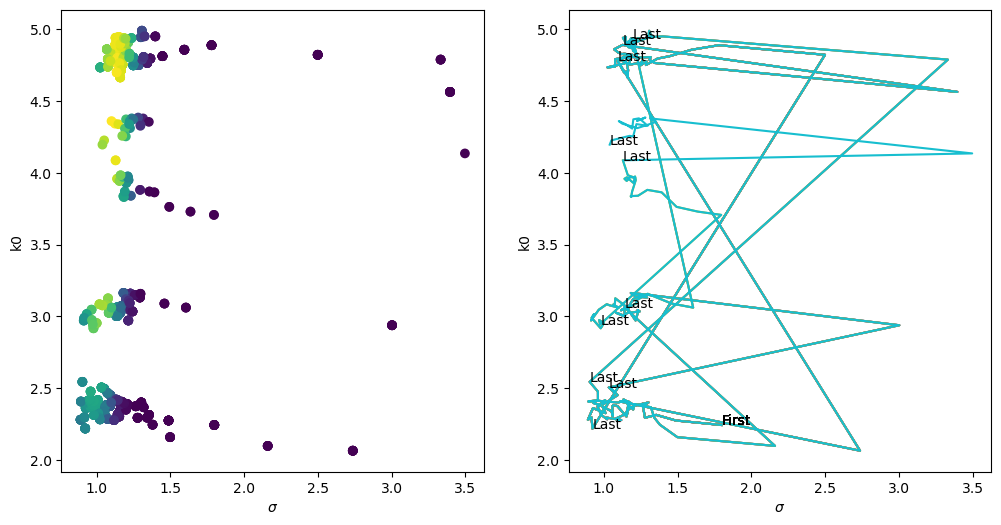

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6))
original_par = np.array([0.8, 2])
path = Path_Tracker()
for i in range(10):
    new_par = list(abs(original_par + np.random.random(size = 2)*3))
    GP = Gaussian_Process(x_dat = rand_coords, t_dat = rand_vals, hyper_par = new_par, noise = 1e-2)
    par, neglog, iter = GP.optimize_par(HMC, sigma = 2, mass = 5, dt = 1e-2, path = path)
    print(path.get_prediction())
    plot_x = np.array(path.x_steps)[:,0]
    plot_y = np.array(path.x_steps)[:,1]
    ax1.scatter(plot_x, plot_y, c = path.likelihood)
    ax2.text(*(path.x_steps[0]), 'First')
    ax2.text(*(path.x_steps[-1]), 'Last')
    ax2.plot(plot_x, plot_y)
    ax1.set_ylabel('k0')
    ax2.set_ylabel('k0')
    ax1.set_xlabel('$\sigma$')
    ax2.set_xlabel('$\sigma$')

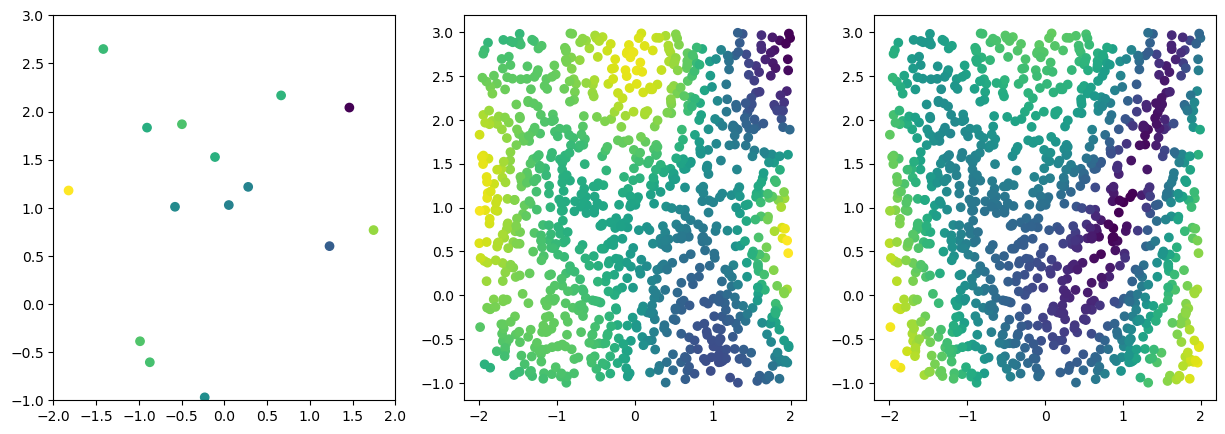

In [16]:
GP = Gaussian_Process(x_dat = rand_coords, t_dat = rand_vals, hyper_par = path.get_prediction(), noise = 1e-2)
plot_vals = GP.predict(plot_coords)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 5))

ax1.scatter(rand_coords[:,0], rand_coords[:,1], c = rand_vals)
ax1.set_xlim(-2,2)
ax1.set_ylim(-1,3)
ax2.scatter(plot_coords[:,0], plot_coords[:,1], c = plot_vals)
ax3.scatter(plot_coords[:,0], plot_coords[:,1], c = func2D(plot_coords.T))